ProgEcon: Project 1

Group: Nikolaj Bysted and Fanny Troelsen Vindeløv


In [1]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

# APIs
from fredapi import Fred
from dstapi import DstApi

# Plotting
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

# 1. Aggregate inflation in Denmark

## 1.1 Basic


We are using table PRIS113 from Denmark Statistics to examine the post-pandemic inflation surge end in Denmark.

__Summary of Findings:__

**Figure 1: Consumer Price Index (2020=100)** : shows a clear level shift upward after 2020.  
**Figure 2: Monthly inflation rate (m/m)** : spikes strongly around 2021–2022.  
**Figure 3: 12-month inflation rate (y/y)** : rises sharply to about 10% in 2022, then drops steeply and stabilizes around 2% from mid-2023 onward.  

The post-pandemic inflation surge in Denmark ended around mid-2023, when the 12-month inflation rate fell back to a low and stable level consistent with pre-pandemic norms.


In [2]:
# 1) Data form DST PRIS 113
PRIS113 = DstApi('PRIS113')  
PRIS113.tablesummary(language='en')

Table PRIS113: Consumer price index by type and time
Last update: 2026-01-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,552,1980M01,1980M01,2025M12,2025M12,True


In [3]:
# 2) Generatring data frame 

# a) Parameters  
params = {
    'table': 'PRIS113',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['INDEKS']},  # CPI
        {'code': 'TID',  'values': ['*']}        # Time 
    ]
}
# b) Downloading data with parameter  
cpi = PRIS113.get_data(params=params)

# # c) Displaying data  
# display(cpi.head(5))
# display(cpi.info())

# d) Renaming variables  
cpi = cpi.rename(columns={'INDHOLD': 'P'})
cpi['Time'] = pd.to_datetime(cpi['TID'], format='%YM%m')
cpi = cpi.sort_values('Time').reset_index(drop=True)

# e) Changing type  
cpi['P'] = cpi['P'].astype(float)

# f) Index  
m2020 = cpi['Time'].dt.year == 2020
base = cpi.loc[m2020, 'P'].mean()
cpi['P_2020=100'] = cpi['P'] / base * 100

# g) Inflation 
cpi['pi'] = cpi['P'].pct_change(1) # month to month inflation 
cpi['pi12'] = cpi['P'].pct_change(12) # 12-month inflation

# h) Droping columns  
cpi = cpi.drop(columns=['TYPE', 'TID'])  


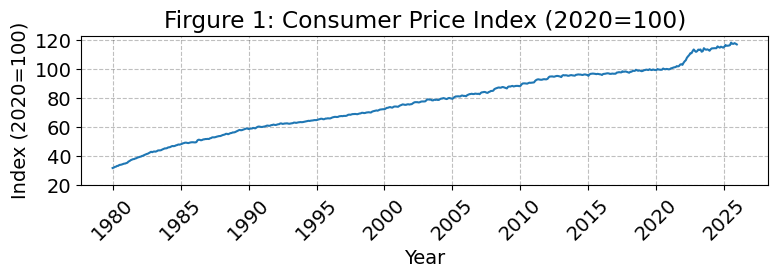

In [4]:
#Figures

# a) Index
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(cpi['Time'], cpi['P_2020=100'], color=colors[0])
ax.set_title('Firgure 1: Consumer Price Index (2020=100)')
ax.set_xlabel('Year')
ax.set_ylabel('Index (2020=100)')
ax.set_yticks([20, 40, 60, 80, 100, 120])
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

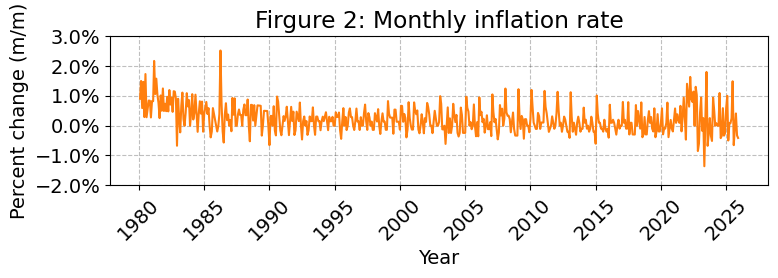

In [5]:
# b) month to month inflation
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(cpi['Time'], cpi['pi'], color=colors[1])
ax.set_title('Firgure 2: Monthly inflation rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percent change (m/m)')
ax.set_yticks([-0.02, -0.01, 0, 0.01, 0.02, 0.03]) 
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


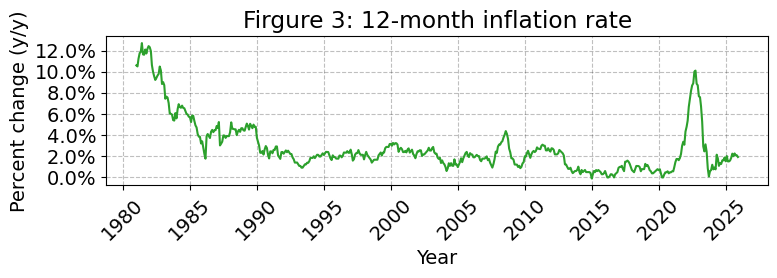

In [6]:
# c) 12-month inflation
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(cpi['Time'], cpi['pi12'], color=colors[2])
ax.set_title('Firgure 3: 12-month inflation rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percent change (y/y)')
ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]) 
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

## 1.2 Instantaneous
The instantaneous inflation rate is defined as:
$$
\begin{align*}
\pi_t^{12,\alpha} &= \left( \prod_{k=0}^{11} (1 + \pi_{t-k})^{\kappa(k,\alpha)} \right) - 1, \\[6pt]
\kappa(k,\alpha) &= \frac{(T - k)^{\alpha}}{\sum (T - k)^{\alpha} \, }T
\end{align*}
$$

__Summary of Findings:__

__Figure 4__ shows that larger α makes the measure more responsive by recent inflation changes, while α = 0 gives equal weights across all 12 months.

__Figure 5__ shows that the instantaneous 12-month inflation peaked around mid-2022 and returned near zero by early 2023. This suggests that the post-pandemic inflation surge ended slightly earlier than indicated by the year-over-year measure.



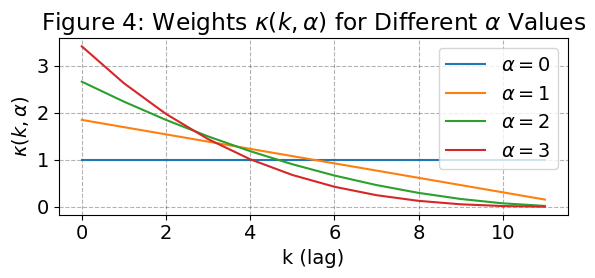

In [7]:
# 1) Creating function 
# Define kappa
def kappa(alpha, T=12):
    k = np.arange(T)
    return k, (T - k)**alpha / np.sum((T - np.arange(T))**alpha) * T

# The weights for alpha
alphas = [0, 1, 2, 3]

# 2) Plot kappa with weights 
# a) Creating figure
fig, ax = plt.subplots(figsize=(6, 3))
for a in alphas:
    k, w = kappa(a)
    ax.plot(k, w, label=fr'$\alpha={a}$')

# 3) Labels and style
ax.set_title(r'Figure 4: Weights $\kappa(k, \alpha)$ for Different $\alpha$ Values')
ax.set_xlabel('k (lag)')
ax.set_ylabel(r'$\kappa(k, \alpha)$')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
# 3) Computing inflation year 
def inflation_year(pi, alpha, T=12):
    _, w_k = kappa(alpha, T)
    w = w_k[::-1]  

    # a) Rolling 
    res = pi.rolling(12).apply(
        lambda x: np.prod((1 + x)**w) - 1,
        raw=True
    )
    return res

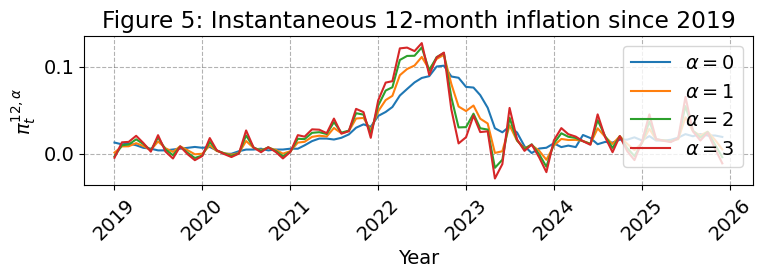

In [9]:
# 4) Plots instantaneous inflation since 2019
# a) Creating figure
fig, ax = plt.subplots(figsize=(8, 3))
for a in alphas:
    pi_year = inflation_year(cpi['pi'], a) 
    mask_2019 = cpi['Time'] >= '2019-01-01'
    time_2019 = cpi.loc[mask_2019, 'Time']
    pi_2019 = pi_year[mask_2019]
    
    ax.plot(time_2019, pi_2019, label=fr'$\alpha={a}$')

# b) Labels and style
ax.set_title("Figure 5: Instantaneous 12-month inflation since 2019")
ax.set_ylabel(r'$\pi_t^{12,\alpha}$')
ax.set_xlabel("Year")
ax.legend()
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.3 Core inflation

Using the PRIS111 table from Statistics Denmark, we construct a figure showing 12-month inflation rates since 2019. 

__Summary of Findings:__

__Figure 6__ reveals that the total CPI increased far more sharply than the series excluding energy, indicating that energy prices were the primary driver of the post-pandemic inflation surge. As energy prices normalised, the inflation measures converged, demonstrating that underlying core inflation pressures were considerably more moderate

In [10]:
# 1) data DST PRIS111
PRIS111 = DstApi('PRIS111')  
PRIS111.tablesummary(language='en')

Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2026-01-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,VAREGR,385,000000,"00 Consumer price index, total",151000,15.1 Overall Consumer Price Index excl. energy,False
1,ENHED,3,100,Index,300,Percentage change compared to same month the y...,False
2,Tid,300,2001M01,2001M01,2025M12,2025M12,True


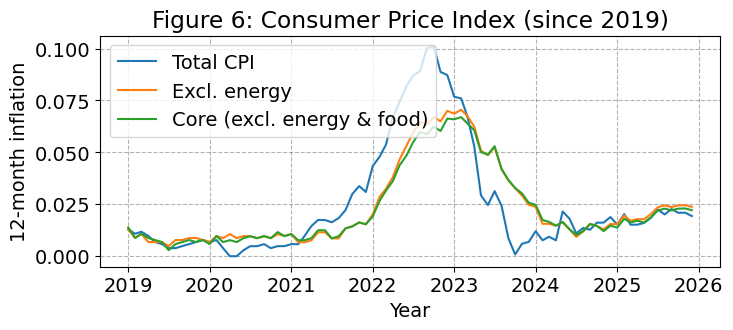

In [11]:
# 2) Generatering data frame 
# a) data form DST PRIS111 
params_v2 = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': ['000000', '151000', '141000']},  # total, excl. energy, core
        {'code': 'ENHED',  'values': ['100']},                         # "Index"
        {'code': 'Tid',    'values': ['*']}                            # all months
    ]
}

cpi_v2 = PRIS111.get_data(params=params_v2)


# b) Renaming and sorting
cpi_v2 = cpi_v2.rename(columns={'INDHOLD':'P', 'TID':'Time'})
cpi_v2['Time'] = pd.to_datetime(cpi_v2['Time'], format='%YM%m')
cpi_v2['P'] = pd.to_numeric(cpi_v2['P'], errors='coerce')
cpi_v2 = cpi_v2.sort_values(['VAREGR','Time']).reset_index(drop=True)
cpi_v2['pi12'] = cpi_v2.groupby('VAREGR')['P'].pct_change(12) # 12 mouth inflation 


# 3) Plot since 2019
series_dict = {
    'Total CPI'                     : cpi_v2['VAREGR'].str.startswith('00 '),
    'Excl. energy'                  : cpi_v2['VAREGR'].str.startswith('15.1 '),
    'Core (excl. energy & food)'    : cpi_v2['VAREGR'].str.startswith('14.1 ')
}

fig, ax = plt.subplots(figsize=(8,3))
for name, mask in series_dict.items():
    df = cpi_v2.loc[mask]
    df = df[df['Time'] >= '2019-01-01']
    ax.plot(df['Time'], df['pi12'], label=name)


ax.set_title("Figure 6: Consumer Price Index (since 2019)")
ax.set_xlabel("Year")
ax.set_ylabel("12-month inflation")
ax.legend()
ax.grid(alpha=0.3)
plt.show()


## 1.4 Disaggregated inflation in Denmark

Using the PRIS111 table from Statistics Denmark to construk 12-month inflation rate for the 4-digit product categories

__Summary of Findings:__

__Figure 7__ shows of 12-month inflation across 4-digit product categories over time computed into the 25th, 50th and 75th percentile. The distribution remains  stable until inflation rises sharply in 2021–2023, where both the median and the upper percentile increase relativly more than the lower percentile.

__Figure 8__ illustrates that five-year price changes from 2020 to 2025 are right-skewed, with most categories experiencing moderate increases while a small number of goods display exceptionally large price rises and a few categories show outright declines.

__Figures 9 and 10__ show that the largest cumulative price increases from 2020 to 2025 are concentrated in services, tobacco products, and several food categories, while the smallest or negative price changes are primarily found in electronics, kitchenware, books, and certain household goods. This contrast highlights that the inflation shock affected product categories unevenly.

C:\Users\fanny\AppData\Local\Temp\ipykernel_76032\249743449.py:34: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  100 * cpi_4digit.groupby('VAREGR')['P'].pct_change(12)


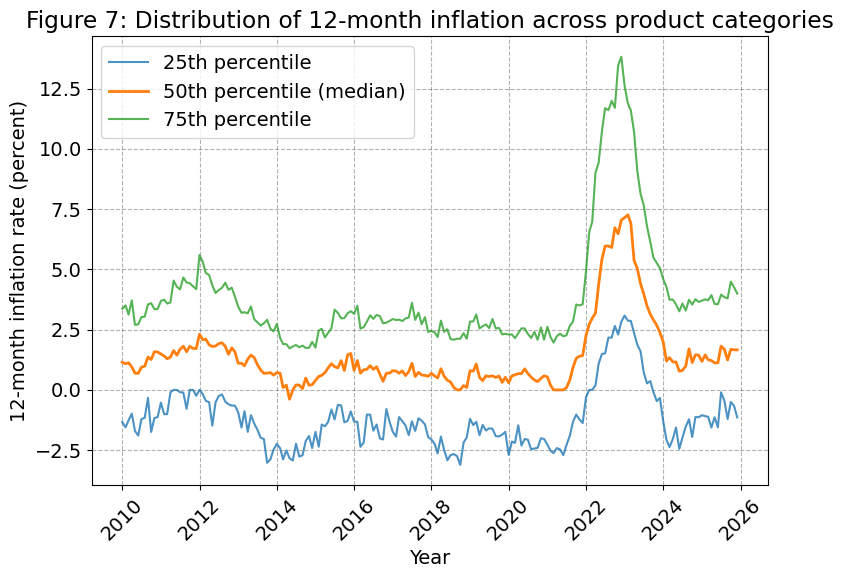

In [12]:
# # 1) list of all 4-digit product categories
levels = PRIS111.variable_levels('VAREGR', language='en')

four_digit_codes = []
for row in levels.itertuples():
    # Only categories where the 5th character is not '0' 
    if len(row.id) == 6 and row.id[4] != '0':
        four_digit_codes.append(row.id)

# 2) Generating data frame 
# a Creatring params for all 4-digit categories
params_4digit = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': four_digit_codes},
        {'code': 'ENHED',  'values': ['100']},     # Index (2020=100)
        {'code': 'Tid',    'values': ['*']}        # all months
    ]
}

cpi_4digit = PRIS111.get_data(params=params_4digit)

# b) Renaming and sorting
cpi_4digit = cpi_4digit.rename(columns={'INDHOLD':'P', 'TID':'Time'})
cpi_4digit['Time'] = pd.to_datetime(cpi_4digit['Time'], format='%YM%m')
cpi_4digit['P'] = pd.to_numeric(cpi_4digit['P'], errors='coerce')

cpi_4digit = cpi_4digit.sort_values(['VAREGR','Time']).reset_index(drop=True)

# c) 12-month inflation for each 4-digit category
cpi_4digit['pi12'] = (
    100 * cpi_4digit.groupby('VAREGR')['P'].pct_change(12)
)

# d) Calculating percentiles for each month
monthly_percentiles = cpi_4digit.groupby('Time')['pi12'].agg([
    lambda x: x.quantile(0.25),   # 25th percentile
    lambda x: x.quantile(0.50),   # median
    lambda x: x.quantile(0.75)    # 75th percentile
]).reset_index()

monthly_percentiles.columns = ['Time', 'p25', 'p50', 'p75']

# 3) figure

# a) Filter period 2010–2025
start = pd.Timestamp('2010-01-01')
end   = pd.Timestamp('2025-12-31')

monthly_percentiles_sub = monthly_percentiles[
    (monthly_percentiles['Time'] >= start) &
    (monthly_percentiles['Time'] <= end)
].copy()


# b) Plot
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(monthly_percentiles_sub['Time'], monthly_percentiles_sub['p25'],
        label='25th percentile', alpha=0.8)

ax.plot(monthly_percentiles_sub['Time'], monthly_percentiles_sub['p50'],
        label='50th percentile (median)', linewidth=2)

ax.plot(monthly_percentiles_sub['Time'], monthly_percentiles_sub['p75'],
        label='75th percentile', alpha=0.8)

ax.set_title('Figure 7: Distribution of 12-month inflation across product categories')
ax.set_xlabel('Year')
ax.set_ylabel('12-month inflation rate (percent)')

ax.legend()
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


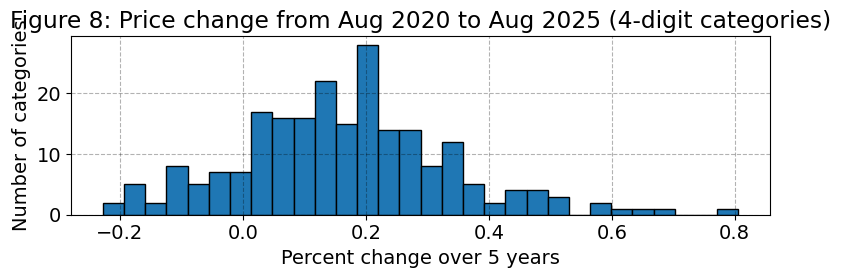

In [13]:
# 4) Change in percent 

# a) Filter data for Aug 2020 and Aug 2025, then pivot
dates_to_filter = pd.to_datetime(['2020-08-01', '2025-08-01'])
subset = cpi_4digit[cpi_4digit['Time'].isin(dates_to_filter)]
price_change = subset.pivot(index='VAREGR', columns='Time', values='P')

# b) Calculating percent change
price_change['pct_change'] = (price_change['2025-08-01'] / price_change['2020-08-01'] - 1)

# c) Droping missing categories
price_change = price_change.dropna(subset=['pct_change'])

# 5) Histogram
fig, ax = plt.subplots(figsize=(8,3))
ax.hist(price_change['pct_change'], bins=30, edgecolor='k')
ax.set_title('Figure 8: Price change from Aug 2020 to Aug 2025 (4-digit categories)')
ax.set_xlabel('Percent change over 5 years')
ax.set_ylabel('Number of categories')
ax.grid(alpha=0.3)
plt.tight_layout() 
plt.show()

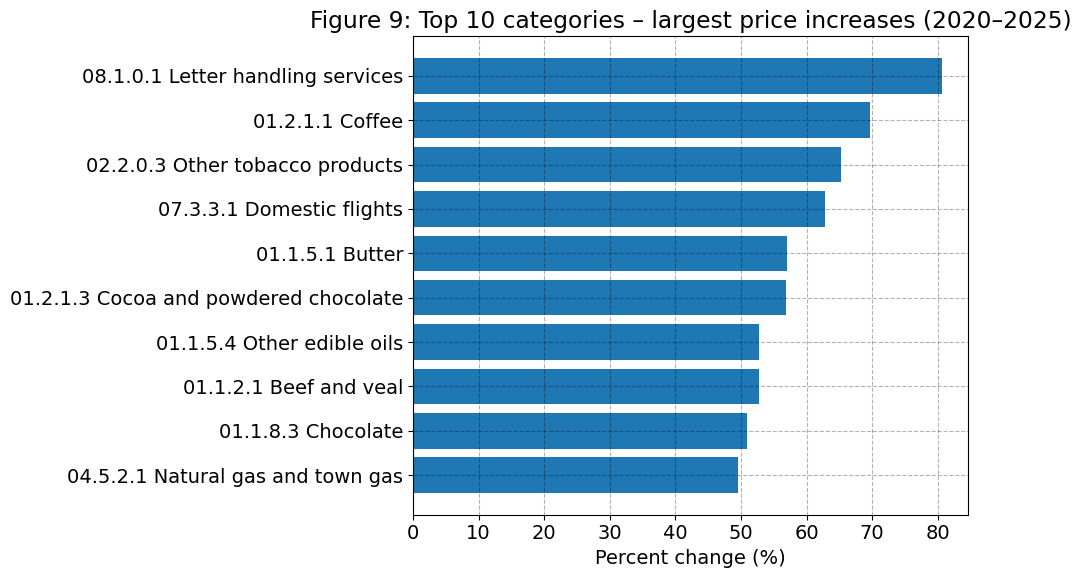

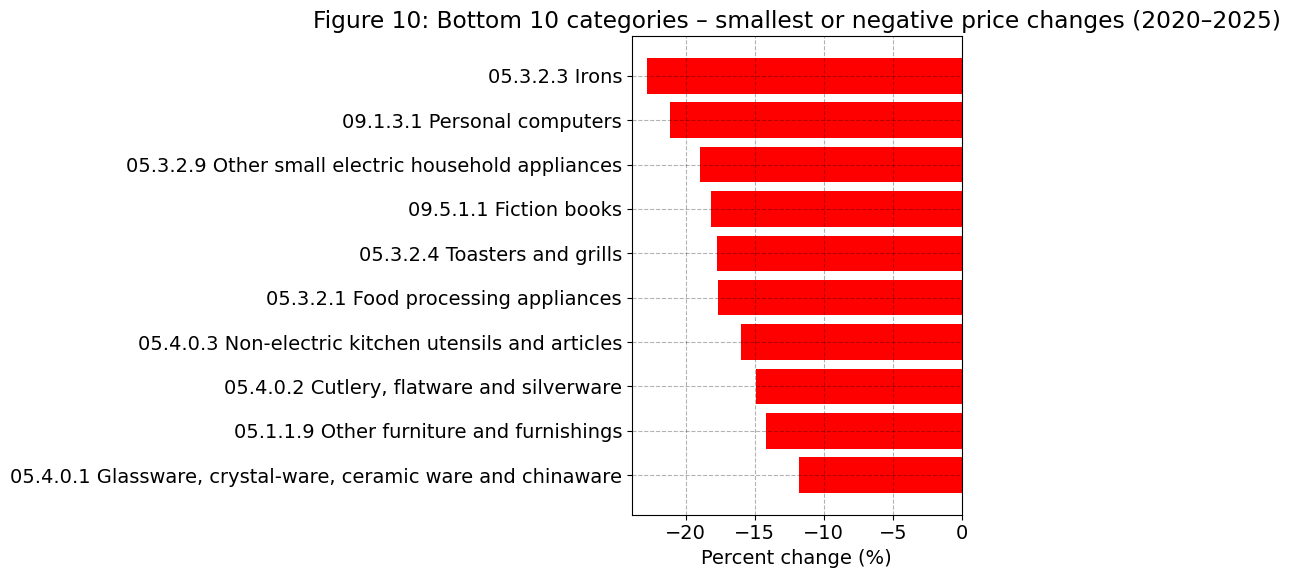

In [14]:
# 6) Top 10 and bund 10
top10 = price_change.nlargest(10, 'pct_change')
bottom10 = price_change.nsmallest(10, 'pct_change')


# 7) Bar Plots
# a) Top 10 
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(top10.index[::-1], (top10['pct_change']*100).iloc[::-1])
ax.set_title('Figure 9: Top 10 categories – largest price increases (2020–2025)')
ax.set_xlabel('Percent change (%)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# b) Bottom 10 
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(bottom10.index[::-1], (bottom10['pct_change']*100).iloc[::-1], color='red')
ax.set_title('Figure 10: Bottom 10 categories – smallest or negative price changes (2020–2025)')
ax.set_xlabel('Percent change (%)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. International Comparison

## 2.1 CPI vs HICP

__Summary of Findings:__

 __Figure 11__ compares Denmark’s CPI (from Statistics Denmark) with the HICP series obtained from FRED, both rebased to 2020 = 100. The two indices track each other extremely closely over the entire period. Although HICP shows slightly stronger growth in the early years, and CPI shows marginally higher values around 2021–2023, the overall trajectories are nearly identical.
The correlation between the two measures is effectively perfect, confirming that CPI and HICP provide highly consistent signals about inflation dynamics in Denmark. Any small differences appear to be driven by methodological distinctions, such as weighting schemes, rather than structural economic divergence.

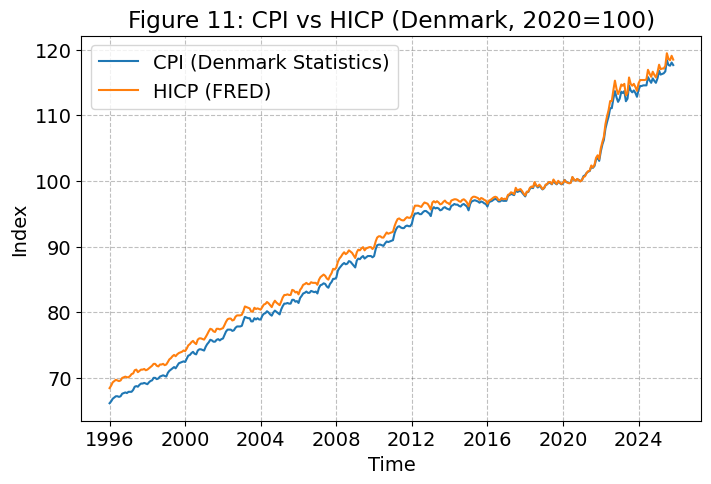

Correlation between CPI and HICP: 0.9994567884060289


In [15]:
# --- Assignment 2.1: CPI vs HICP ---------------------------------------------

# 1) connecting to FRED)
fred = Fred(api_key='c3a776f71a15da1b61d81dfde7d34030')

# 2) downloading HICP for Denmark
hicp = fred.get_series('CP0000DKM086NEST')
hicp = hicp.reset_index()
hicp.columns = ['Time', 'HICP']

# 3) align with your CPI data
df = pd.merge(cpi[['Time', 'P_2020=100']], hicp, on='Time', how='inner')

# 4) rebasing HICP to 2020 = 100
mask_2020 = df['Time'].dt.year == 2020
base_hicp = df.loc[mask_2020, 'HICP'].mean()
df['HICP_2020=100'] = df['HICP'] / base_hicp * 100

# 5) plot comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df['Time'], df['P_2020=100'], label='CPI (Denmark Statistics)')
plt.plot(df['Time'], df['HICP_2020=100'], label='HICP (FRED)')
plt.title('Figure 11: CPI vs HICP (Denmark, 2020=100)')
plt.ylabel('Index')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

# 6) optional: correlation check
print("Correlation between CPI and HICP:", df['P_2020=100'].corr(df['HICP_2020=100']))

## 2.2 Across countries

__Summary of Findings:__

 __Figure 12__ shows that price levels (HICP/CPI rebased to 2020 = 100) increased steadily across all countries from 2019 to 2025, with Austria and the Euro Area experiencing the largest cumulative price growth. Denmark and the United States display a more moderate trajectory, although all four economies follow a similar timing in the overall price rise.


__Figure 13__ illustrates that inflation rates peaked in 2022 in every country, with the United States experiencing the earliest and most pronounced spike, followed by Austria and the Euro Area. Denmark shows a more muted inflation cycle but follows the same general pattern. After 2022, inflation declined substantially across all countries.


The descriptive statistics shown in __tabel 1__ confirm these patterns: 2022 stands out as the year with the highest average, minimum, and maximum inflation across all countries, while 2023–2024 mark a clear normalization phase. The results highlight that despite differences in magnitude, the timing and shape of the inflation cycle were broadly synchronized across countries.

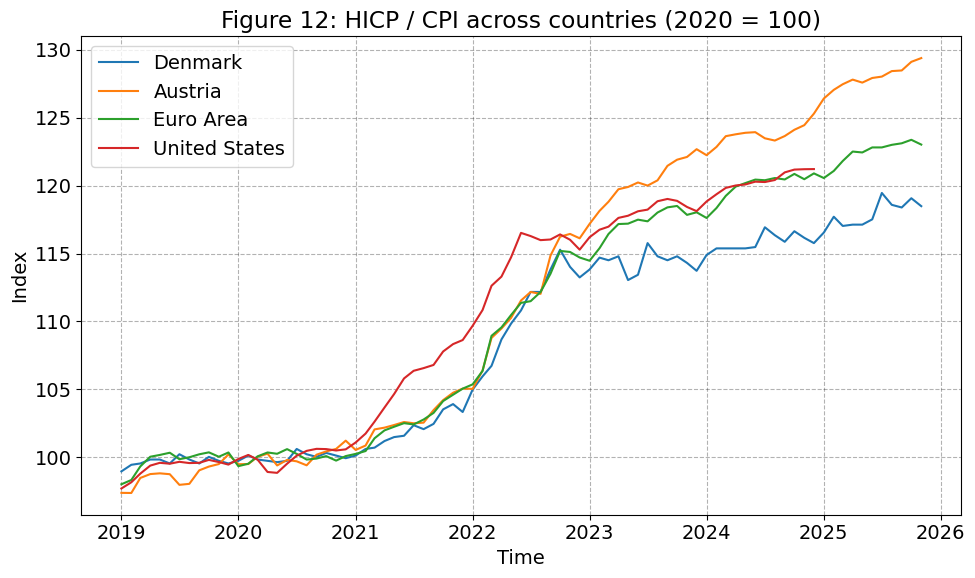

In [16]:
# --- Assignment 2.2: Across countries ----------------------------------------

# Use only series that are available on FRED
codes = {
    'Denmark': 'CP0000DKM086NEST',
    'Austria': 'CP0000ATM086NEST',
    'Euro Area': 'CP0000EZ19M086NEST',
    'United States': 'CP0000USM086NEST'
}

data = pd.DataFrame()
for country, code in codes.items():
    # Download each country’s CPI/HICP series from FRED
    series = fred.get_series(code)
    df = pd.DataFrame(series).rename(columns={0: country})
    data = pd.concat([data, df], axis=1)

# Set index name and keep data from 2019 onward
data.index.name = 'Time'
data = data[data.index >= '2019-01-01']

# Rebase all series to 2020 = 100
base_mask = (data.index.year == 2020)
base_values = data.loc[base_mask].mean()
data_indexed = data / base_values * 100

# Plot the rebased indices for comparison
plt.figure(figsize=(10,6))
for col in data_indexed.columns:
    plt.plot(data_indexed.index, data_indexed[col], label=col)
plt.title('Figure 12: HICP / CPI across countries (2020 = 100)')
plt.ylabel('Index')
plt.xlabel('Time')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\fanny\AppData\Local\Temp\ipykernel_76032\3853496462.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  infl = data.pct_change(12) * 100


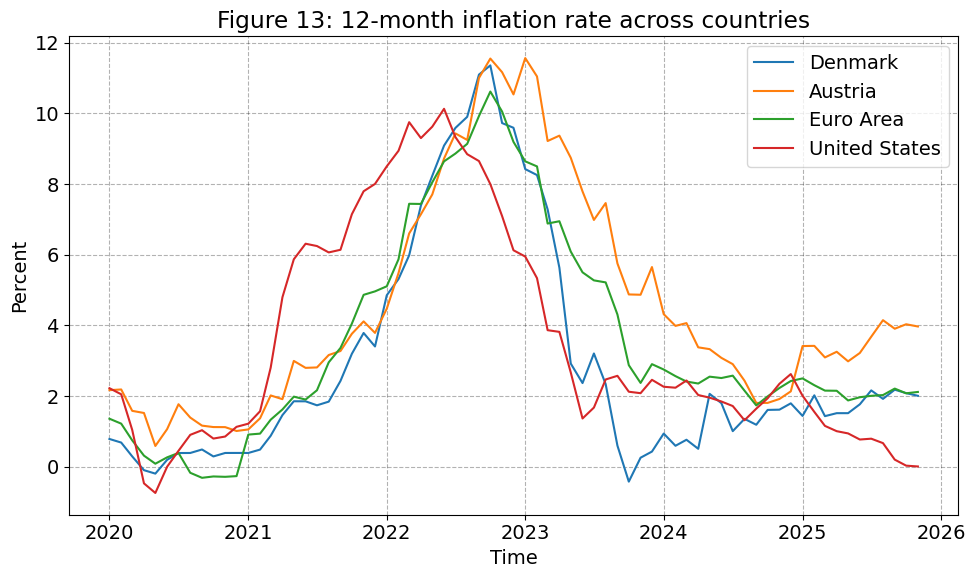

In [17]:
# Compute 12-month inflation rates
infl = data.pct_change(12) * 100

# Plot the annual inflation rates
plt.figure(figsize=(10,6))
for col in infl.columns:
    plt.plot(infl.index, infl[col], label=col)
plt.title('Figure 13: 12-month inflation rate across countries')
plt.ylabel('Percent')
plt.xlabel('Time')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\fanny\AppData\Local\Temp\ipykernel_76032\3853496462.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  infl = data.pct_change(12) * 100


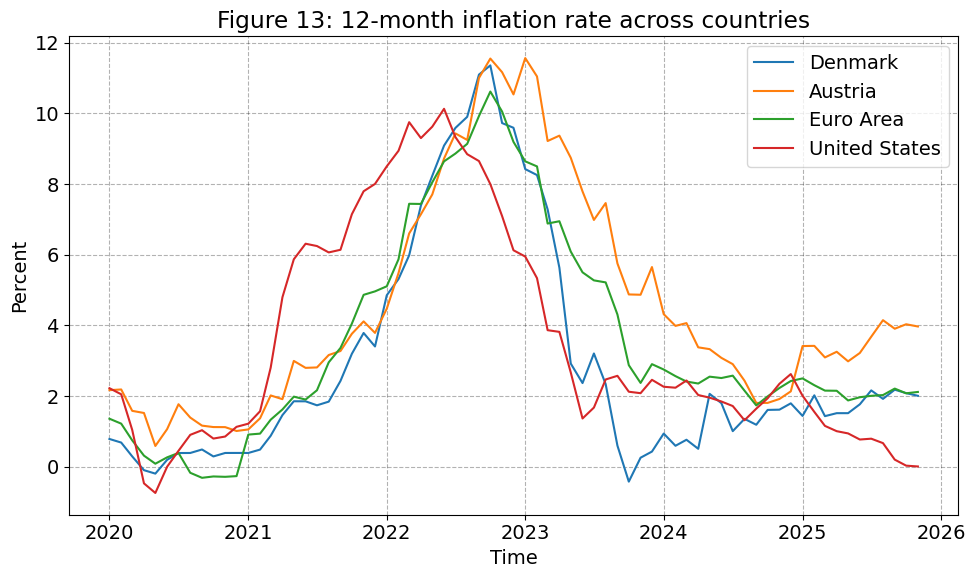

In [18]:
# Compute 12-month inflation rates
infl = data.pct_change(12) * 100

# Plot the annual inflation rates
plt.figure(figsize=(10,6))
for col in infl.columns:
    plt.plot(infl.index, infl[col], label=col)
plt.title('Figure 13: 12-month inflation rate across countries')
plt.ylabel('Percent')
plt.xlabel('Time')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Summarize annual min, max, and mean inflation
print("Tabel 1: Annual min, max, and mean inflation rates across countries")

infl['Year'] = infl.index.year
summary = infl.groupby('Year')[list(codes.keys())].agg(['min', 'max', 'mean'])
display(summary.round(2))


Tabel 1: Annual min, max, and mean inflation rates across countries


Denmark              Austria              Euro Area               \
         min    max  mean     min    max  mean       min    max  mean   
Year                                                                    
2019     NaN    NaN   NaN     NaN    NaN   NaN       NaN    NaN   NaN   
2020   -0.19   0.79  0.33    0.59   2.19  1.39     -0.31   1.36  0.26   
2021    0.39   3.79  1.94    1.06   4.11  2.76      0.91   4.96  2.59   
2022    4.85  11.36  8.51    4.48  11.55  8.59      5.11  10.62  8.36   
2023   -0.42   8.43  3.44    4.87  11.57  7.78      2.37   8.64  5.46   
2024    0.51   2.06  1.27    1.81   4.32  2.93      1.74   2.75  2.36   
2025    1.43   2.18  1.82    2.98   4.15  3.56      1.88   2.50  2.13   

     United States               
               min    max  mean  
Year                             
2019           NaN    NaN   NaN  
2020         -0.74   2.22  0.77  
2021          1.22   8.01  5.33  
2022          6.13  10.13  8.69  
2023          1.37   5.95  3.03  
2024          1.32   2.62  2.03  
2025          0.01   2.01  0.83

# 3. Extension

__Summary of Findings :__

Across all countries, inflation increased sharply during 2021–2022, and __Figure 14__ shows that this rise closely mirrors the surge in global oil prices. This pattern suggests that energy costs were a key driver of the inflationary spike.

In __Figure 15__, we see that policy rates in the Euro Area reacted with a noticeable delay, rising only after inflation had already peaked—consistent with the typical lag in monetary policy responses.

The descriptive statistics shown in __tabel 2__ further indicate that 2022 stands out as the year with the highest average inflation, followed by a gradual normalization in 2023–2024. Overall, the evidence points to a strong link between energy markets and the inflation surge, combined with a delayed but decisive monetary policy tightening.

C:\Users\fanny\AppData\Local\Temp\ipykernel_76032\371476611.py:21: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  infl_12m = inflation.pct_change(12) * 100


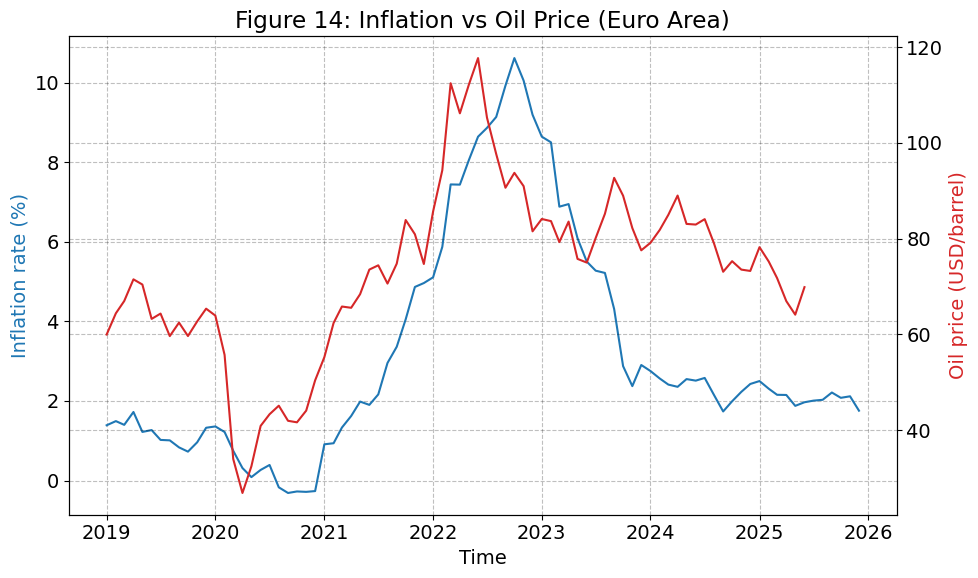

In [20]:
# --- Assignment 3: Inflation Analysis ---------------------------------------------

# Baseline inflation data (fred object already defined earlier)
codes = {
    'Denmark': 'CP0000DKM086NEST',
    'Austria': 'CP0000ATM086NEST',
    'Euro Area': 'CP0000EZ19M086NEST',
    'United States': 'CPIAUCSL'
}

# Load CPI/HICP series for each country
inflation = pd.DataFrame()
for country, code in codes.items():
    series = fred.get_series(code)
    df = pd.DataFrame(series).rename(columns={0: country})
    inflation = pd.concat([inflation, df], axis=1)

inflation.index.name = 'Time'

# --- Compute 12-month inflation before restricting the sample ---
infl_12m = inflation.pct_change(12) * 100

# Now restrict to data from 2019 onwards
inflation = inflation[inflation.index >= '2019-01-01']
infl_12m = infl_12m[infl_12m.index >= '2019-01-01']

# --- Load additional macro variables (energy + interest rates) ---
extra_codes = {
    'Brent Oil (USD/barrel)': 'POILBREUSDM',
    'US Policy Rate': 'FEDFUNDS',
    'ECB Policy Rate': 'ECBDFR',
    'Denmark Policy Rate': 'IRLTLT01DKM156N'
}

extra_data = pd.DataFrame()
for name, code in extra_codes.items():
    s = fred.get_series(code)
    extra_data[name] = s

# Align sample period
extra_data = extra_data[extra_data.index >= '2019-01-01']

# --- Plot 1: Inflation vs Oil Prices (Euro Area) ---
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(infl_12m.index, infl_12m['Euro Area'], label='Euro Area inflation (12m)', color='tab:blue')
ax1.set_ylabel('Inflation rate (%)', color='tab:blue')
plt.xlabel('Time')

ax2 = ax1.twinx()
ax2.plot(extra_data.index, extra_data['Brent Oil (USD/barrel)'], label='Brent oil price', color='tab:red')
ax2.set_ylabel('Oil price (USD/barrel)', color='tab:red')


plt.title('Figure 14: Inflation vs Oil Price (Euro Area)')
fig.tight_layout()
plt.show()

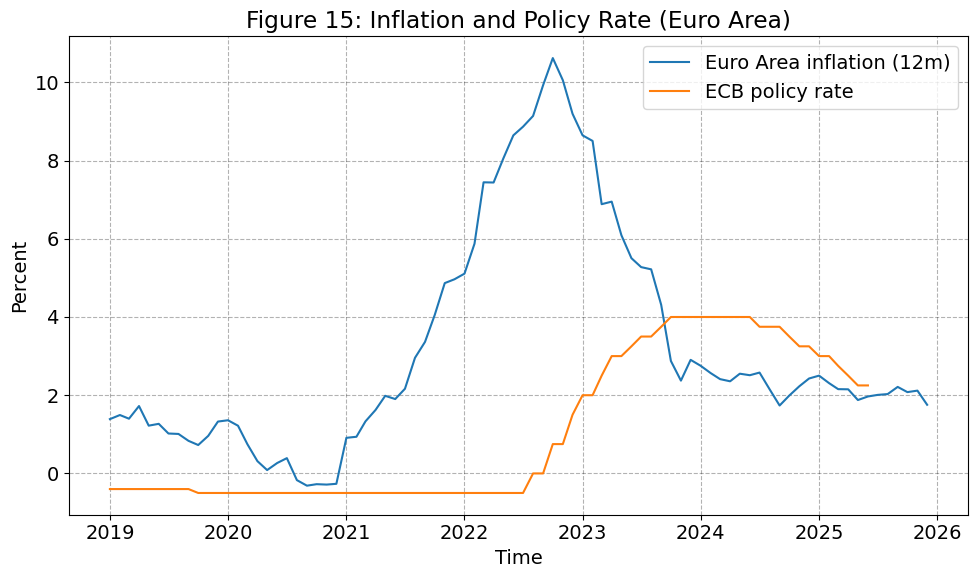

In [21]:
# --- Plot 2: Policy rates and inflation ---
plt.figure(figsize=(10,6))
plt.plot(infl_12m.index, infl_12m['Euro Area'], label='Euro Area inflation (12m)')
plt.plot(extra_data.index, extra_data['ECB Policy Rate'], label='ECB policy rate')
plt.title('Figure 15: Inflation and Policy Rate (Euro Area)')
plt.ylabel('Percent')
plt.xlabel('Time')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
print("Table 2: Annual Average Inflation Rates Across Countries")

# --- Summary table: annual average inflation ---
summary = infl_12m.groupby(infl_12m.index.year).agg(['mean'])
display(summary.round(2))

Table 2: Annual Average Inflation Rates Across Countries


,Denmark,Austria,Euro Area,United States
,mean,mean,mean,mean
Time,,,,
2019,0.73,1.49,1.20,1.81
2020,0.33,1.39,0.26,1.25
2021,1.94,2.76,2.59,4.67
2022,8.51,8.59,8.36,8.00
2023,3.44,7.78,5.46,4.15
2024,1.27,2.93,2.36,2.95
2025,1.87,3.53,2.10,2.70
